In [41]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', '..')))

import src.graphs_generation as graphs_generation

# Stimulus visualization:

Visualization of single stimulus to make sure it is created correctly:

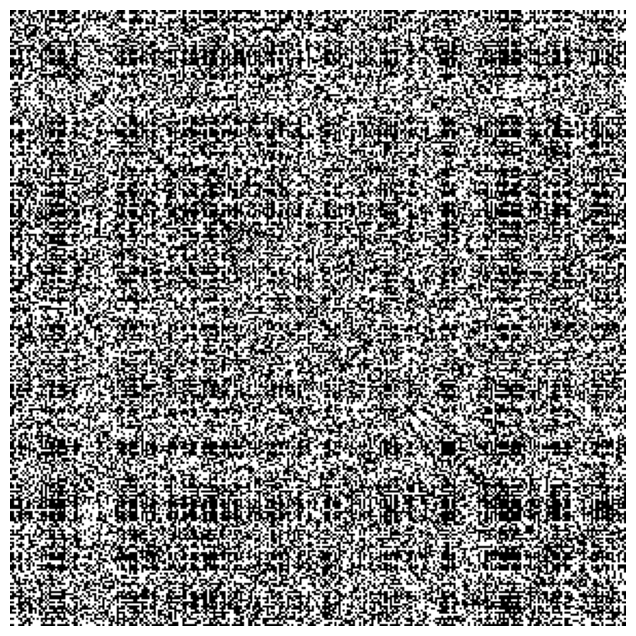

In [45]:
# visualizing input for graph of 160 nodes and clique of 70, "p_increase"
no_resize_graph = graphs_generation.generate_batch(1, 300, [120], "p_reduce", False, p_clique=1)[0]
# visualizing single image without axes:
plt.figure(figsize=(8, 8))  # Increase the size of the figure
plt.axis('off')  # Remove the axes
plt.imshow(np.squeeze(no_resize_graph), cmap='gray_r')
plt.show()

# Visualization of task difficulty increase:

Visualization of batch of 6 graphs (all with a planted clique) of varying clique size, to make sure the difficulty is appropriately modulated during training

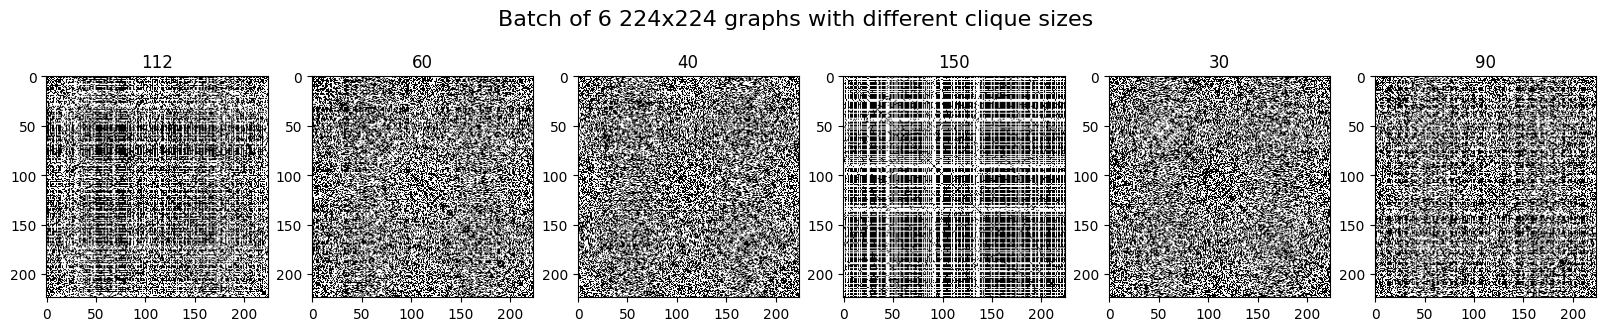

In [46]:
clique_size_array = [112, 60, 40, 150, 30, 90]

graph_batch = graphs_generation.generate_batch(6, 224, clique_size_array, "p_reduce", input_magnification=False, p_clique=1)

# visualizing grid of graphs
n_plots = graph_batch[0].shape[0]
# - Create a figure with appropriate number of subplots
fig, axs = plt.subplots(1, n_plots, figsize=(20, 5))

# - Iterate over the graphs and add them in the right position
for i, graph in enumerate(graph_batch[0]):
    
    # Plot the graph
    axs[i].imshow(graph.squeeze(), cmap="gray_r")
    # Set the clique size as title
    axs[i].set_title(clique_size_array[i])

# Set general title:
plt.suptitle("Batch of 6 224x224 graphs with different clique sizes", fontsize=16, y=0.85)

# plt.tight_layout()

plt.show()

# Visualization of alternative p-corrections:

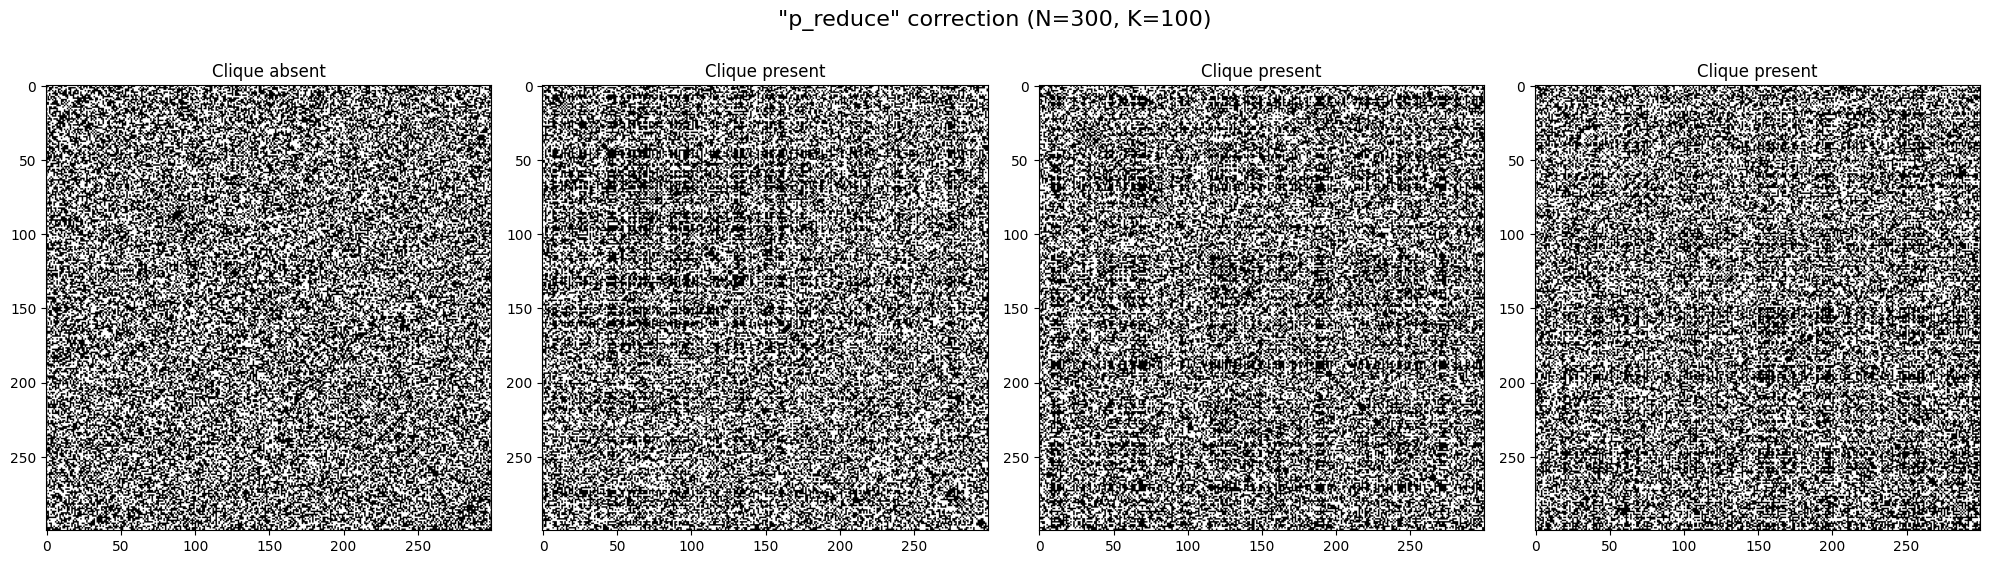

In [47]:
p_correction_type = "p_reduce" # "p_reduce" or "p_increase"

clique_size_array = [100, 100, 100, 100]

graph_batch = graphs_generation.generate_batch(4, 300, clique_size_array, p_correction_type, False)

# visualizing grid of graphs
n_plots = graph_batch[0].shape[0]
# - Create a figure with appropriate number of subplots
fig, axs = plt.subplots(1, n_plots, figsize=(20, 8))

# - Iterate over the graphs and add them in the right position
for i, graph in enumerate(graph_batch[0]):
    
    # Plot the graph
    axs[i].imshow(graph.squeeze(), cmap='gray_r')
    # Set the clique size and the presence or absence of the clique as title
    if graph_batch[1][i] == 1:
        title = "Clique present"
    elif graph_batch[1][i] == 0:
        title = "Clique absent"
    else:
        raise ValueError("Invalid clique presence value: must be 0 or 1")        
    axs[i].set_title(title)

# Set general title:
plt.suptitle(f'"{p_correction_type}" correction (N=300, K={clique_size_array[0]})', fontsize=16, y=0.85)

plt.tight_layout()

plt.show()

# Visualization of planted clique color-coded in red:

In [48]:
import torch 
import math
import matplotlib.pyplot as plt
import numpy as np

In [49]:
def plant_clique_maintain_indices(graph, clique_size, graph_size):
    """
    Plants a clique of specified size within a given graph.

    Args:
        graph (torch.Tensor): Adjacency matrix representing the graph.
        size (int): Size of the clique to be planted.
        graph_size (int): Total number of nodes in the graph.

    Returns:
        torch.Tensor: Modified adjacency matrix with the planted clique.
    """
    # adding the planted clique to the adjacency matrix in the top left corner
    graph[:clique_size, :clique_size] = torch.ones(clique_size, clique_size)
    # creating a random permutation of the nodes
    random_permutation = torch.randperm(graph_size)
    # placing the rows and columns of the adjacency matrix according to the random permutation
    graph = graph[random_permutation[:, None], random_permutation]
    # Returning the modified adjacency matrix and the indices of the nodes in the clique
    clique_indices = random_permutation[:clique_size]
    print(f"Indices of the planted clique: {clique_indices}")    
    return graph, clique_indices

# code to generate a graph with a specific clique size
def generate_graph_clique_indices(
    on_off_label: int,
    graph_size: int,
    clique_size: int,
    p_correction_type: str,
    input_magnification: bool,
    p_nodes: float = 0.5,
):
    """
    Generates a graph with or without a planted clique with the specified correction.

    Args:
        on_off_label (int): Label indicating whether the graph will have a planted clique.
        graph_size (int): Number of nodes in the graph.
        clique_size (int): Size of the planted clique.
        p_correction_type (str): Type of p correction to apply.
        input_magnification (bool): Whether the input needs to be magnified. If True, the graph will be made a 2400x2400 tensor.
        p_nodes (float): Probability of an edge being present between two nodes.

    Raises:
        ValueError: If an invalid p_correction_type is provided.
        ValueError: If the clique size is too large for the graph size and the "p_reduce" correction type is used.

    Returns:
        torch.Tensor: Adjacency matrix representing a graph with the specified features.
    """

    # differentiating between the two types of correction:
    if p_correction_type == "p_increase":
        # (OLD CORRECTION) increasing the p value of the graph without the clique so that the average degree is matched between the two graphs

        # generating lower triangle of the adjacency matrix
        if on_off_label:
            # clique present
            adjacency_matrix = torch.bernoulli(
                p_nodes * torch.ones(graph_size, graph_size)
            )  # regular graph without clique
            # adding clique to adjacency matrix
            adjacency_matrix, clique_indices = plant_clique_maintain_indices(adjacency_matrix, clique_size, graph_size)

        else:
            # clique not present
            p_corrected = p_nodes + (1 - p_nodes) * (
                (clique_size * (clique_size - 1)) / (graph_size * (graph_size - 1))
            )
            adjacency_matrix = torch.bernoulli(
                p_corrected * torch.ones(graph_size, graph_size)
            )

        # generating upper triangular matrix
        upper_triangular = torch.triu(adjacency_matrix)
        adjacency_matrix = upper_triangular + torch.transpose(upper_triangular, 0, 1)
        adjacency_matrix.fill_diagonal_(1)
        # # if input to CNN models, magnify the matrix
        # if input_magnification:
        #     adjacency_matrix = magnify_input(adjacency_matrix)

    elif p_correction_type == "p_reduce":
        # (NEW CORRECTION) reducing the p value of the graph where the clique will be added

        # - making sure that the "p_reduce" corrected probability of association will be positive for requested clique size
        if clique_size > (
            (1 + math.sqrt(1 + 4 * p_nodes * graph_size * (graph_size - 1))) / 2
        ):
            clique_limit = int(
                (1 + math.sqrt(1 + 4 * p_nodes * graph_size * (graph_size - 1))) / 2
            )
            raise ValueError(
                f"Clique size {clique_size} in a graph of size {graph_size} leads to a negative corrected probability of association between nodes. Please choose a clique size smaller than {round(clique_limit)}"
            )

        # generating lower triangle of the adjacency matrix
        if on_off_label:
            # clique present (new correction acts on the reduction of p before adding the clique):
            # - computing the new probability of association
            p_corrected = (
                p_nodes * graph_size * (graph_size - 1)
                - clique_size * (clique_size - 1)
            ) / ((graph_size - clique_size) * (graph_size + clique_size - 1))
            # - creating the new random graph with the probability just computed
            adjacency_matrix = torch.bernoulli(
                p_corrected * torch.ones(graph_size, graph_size)
            )  # regular graph without clique, but with reduced p value
            # adding clique to adjacency matrix
            adjacency_matrix, clique_indices = plant_clique_maintain_indices(adjacency_matrix, clique_size, graph_size)

        else:
            # clique not present (no need to correct)
            adjacency_matrix = torch.bernoulli(
                p_nodes * torch.ones(graph_size, graph_size)
            )

        # generating upper triangular matrix
        upper_triangular = torch.triu(adjacency_matrix)
        adjacency_matrix = upper_triangular + torch.transpose(upper_triangular, 0, 1)
        adjacency_matrix.fill_diagonal_(1)
        # # if input to CNN models, magnify the matrix
        # if input_magnification:
        #     adjacency_matrix = magnify_input(adjacency_matrix)

    else:
        raise ValueError(
            "Invalid p_correction_type. Must be either 'p_increase' or 'p_reduce'"
        )
    
    return adjacency_matrix, clique_indices if on_off_label else None


Indices of the planted clique: tensor([ 76,  40,   5,   8,  23,  92,  47,  26,  89, 143,  15,  99, 121,  67,
         70,  21, 138,  81,  39, 157])


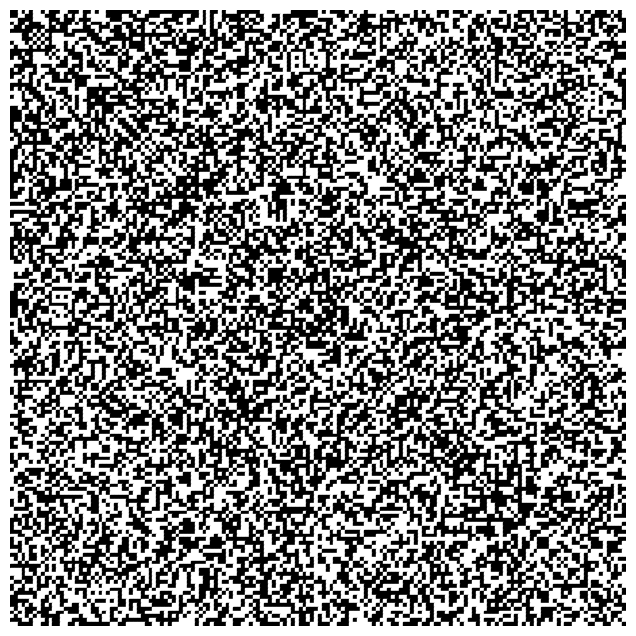

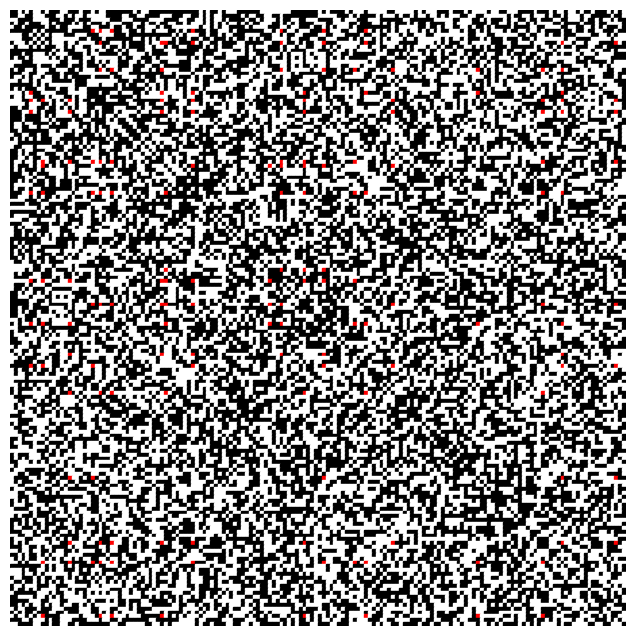

In [50]:
single_graph, clique_indices = generate_graph_clique_indices(1, 160, 20, "p_reduce", False, p_nodes=0.5)

# BLACK/WHITE VISUALIZATION
plt.figure(figsize=(8, 8))
plt.axis('off')
graph_size = single_graph.shape[0]
for i in range(graph_size):
    for j in range(graph_size):
        y = graph_size - 1 - i  # reverse the row index
        if single_graph[i, j] == 1:
            plt.gca().add_patch(plt.Rectangle((j, y), 1, 1, color='black'))
        else:
            plt.gca().add_patch(plt.Rectangle((j, y), 1, 1, color='white'))
plt.xlim(0, graph_size)
plt.ylim(0, graph_size)
plt.gca().set_aspect('equal')
plt.show()

# RED/BLACK/WHITE VISUALIZATION
plt.figure(figsize=(8, 8))
plt.axis('off')
for i in range(graph_size):
    for j in range(graph_size):
        y = graph_size - 1 - i  # reverse the row index
        if single_graph[i, j] == 1:
            if i == j:
                plt.gca().add_patch(plt.Rectangle((j, y), 1, 1, color='black'))
            elif i in clique_indices and j in clique_indices:
                plt.gca().add_patch(plt.Rectangle((j, y), 1, 1, color='red'))
            else:
                plt.gca().add_patch(plt.Rectangle((j, y), 1, 1, color='black'))
        else:
            plt.gca().add_patch(plt.Rectangle((j, y), 1, 1, color='white'))
plt.xlim(0, graph_size)
plt.ylim(0, graph_size)
plt.gca().set_aspect('equal')
plt.show()

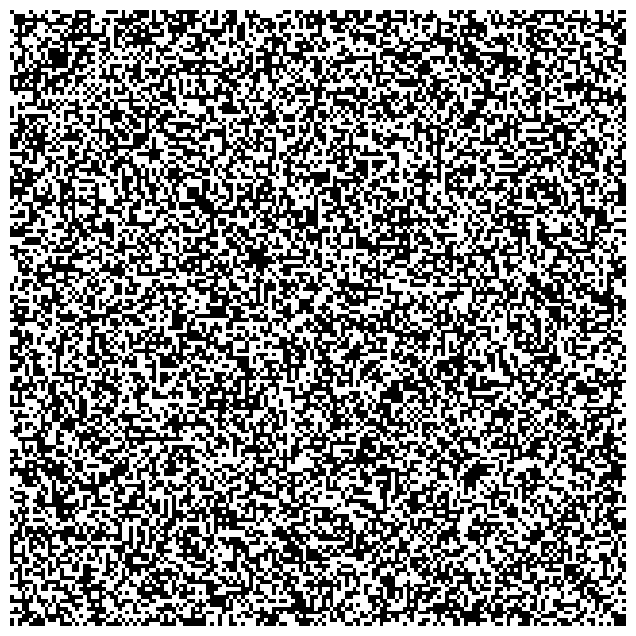

In [39]:
# visualizing single image without axes:
plt.figure(figsize=(8, 8))  # Increase the size of the figure
plt.axis('off')  # Remove the axes
plt.imshow(np.squeeze(single_graph), cmap='gray_r')
plt.show()